In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter 4 - Extending Linear Models

In [22]:
babies = pd.read_csv(os.path.abspath('.') + '/data/babies.csv')
babies

,Month,Length
0,0,48.5
1,0,50.5
2,0,50.5
3,0,52.0
4,0,47.5
...,...,...
795,24,87.5
796,24,82.5
797,24,88.5
798,24,89.0


## 4.1 Transforming Covariates

### Figure 4.2

In [ ]:
X_ = torch.from_numpy(babies['Month'].values.reshape(-1, 1))
X_ = torch.tensor(X_).float()

y = torch.from_numpy(babies['Length'].values)
y = torch.tensor(y).float()

In [24]:
def linear_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, month.T)
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

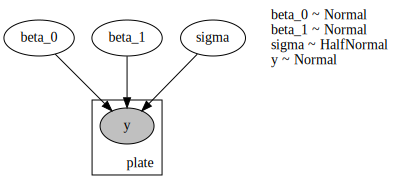

In [25]:
pyro.render_model(
    linear_babies, 
    model_args=(X_, y),
    render_distributions=True
    )

In [26]:
kernel = NUTS(linear_babies, adapt_step_size=True)
mcmc_linear_babies = MCMC(kernel, 500, 300)
mcmc_linear_babies.run(X_, y)

Sample: 100%|██████████| 800/800 [00:11, 70.49it/s, step size=4.43e-01, acc. prob=0.911] 


In [27]:
mcmc_babie_samples = mcmc_linear_babies.get_samples(1000)
predictive = Predictive(linear_babies, mcmc_babie_samples)(X_, None)

az_linear_babies = az.from_pyro(
    posterior=mcmc_linear_babies, posterior_predictive=predictive)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [28]:
y_mu = predictive['y'].mean(axis=0)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


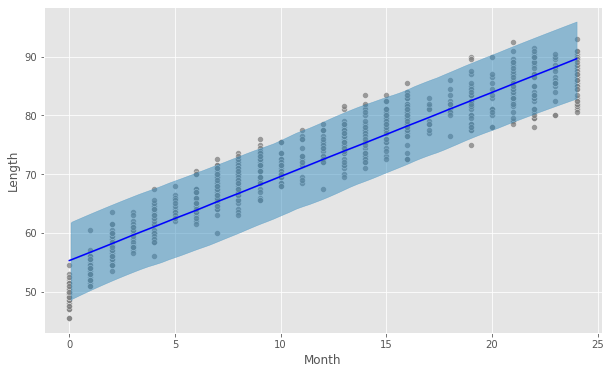

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=babies['Month'], y=babies['Length'], color='grey', alpha=0.75)
sns.lineplot(x=babies['Month'], y=y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=predictive['y'].numpy())
plt.show()

### Figure 4.3

In [30]:
def sqrt_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, torch.sqrt(month.T))
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

In [31]:
kernel = NUTS(sqrt_babies, adapt_step_size=True)
mcmc_sqrt = MCMC(kernel, 500, 300)
mcmc_sqrt.run(X_, y)

Sample: 100%|██████████| 800/800 [00:17, 45.97it/s, step size=2.50e-01, acc. prob=0.949]


In [36]:
mcmc_sqrt_babie_samples = mcmc_sqrt.get_samples(1000)
predictive_sqrt = Predictive(sqrt_babies, mcmc_sqrt_babie_samples)(X_, None)

az_sqrt_babies = az.from_pyro(
    posterior=mcmc_sqrt, posterior_predictive=predictive_sqrt)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [38]:
y_mu = predictive_sqrt['y'].mean(axis=0)

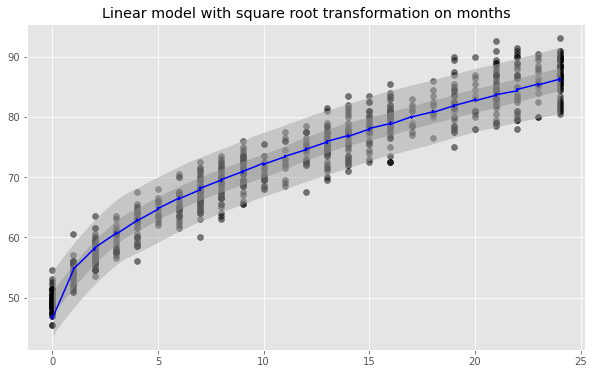

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(babies['Month'], babies['Length'], c='black', alpha=0.5)
plt.plot(babies['Month'], y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.50, color='grey')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.94, color='darkgrey')
plt.title('Linear model with square root transformation on months')
plt.show()

## 4.2 - Varying Uncertainty

## 4.3 - Interaction Effects

In [8]:
tips_df = pd.read_csv(os.path.abspath('.') + '/data/tips.csv')
tips_df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [83]:
total_bill_centered = torch.tensor((tips_df["total_bill"] - tips_df["total_bill"].mean()).values, dtype=torch.float64)
tips = torch.tensor(tips_df["tip"].values, dtype=torch.float64)
smoker = torch.tensor(pd.Categorical(tips_df["smoker"]).codes, dtype=torch.float64)

In [89]:
def interaction_model(bill, smoker, tips=None):
    
    #N, P = 

    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([4]))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    mu = beta[0] + beta[1] * bill + beta[2] * smoker + beta[3] * smoker * bill

    with pyro.plate('plate', len(bill)):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=tips)

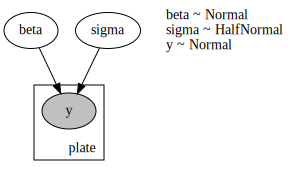

In [90]:
pyro.render_model(
    interaction_model,
    (total_bill_centered, smoker, tips), render_distributions=True)

In [91]:
kernel = NUTS(interaction_model, adapt_step_size=True)
mcmc_interaction = MCMC(kernel, 500, 300)
mcmc_interaction.run(total_bill_centered, smoker, tips)

Sample: 100%|██████████| 800/800 [00:15, 52.72it/s, step size=4.11e-01, acc. prob=0.936]


In [ ]:
mcmc_interaction_samples = mcmc_interaction.get_samples(1000)
interaction_predictive = Predictive(interaction_model, mcmc_interaction_samples)
posterior_predictive = interaction_predictive(total_bill_centered, smoker, None)

az_inference_interaction = az.from_pyro(
    posterior=mcmc_interaction, posterior_predictive=posterior_predictive)

In [117]:
tip_mu = posterior_predictive['y'].mean(axis=0)
tip_std = posterior_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'bill': total_bill_centered,
    'smoker': smoker,
    'tip': tips, 
    'tip_mu': tip_mu,
    'tip_std': tip_std,
    'tip_high': tip_mu + tip_std,
    'tip_low': tip_mu - tip_std
})

predictions = predictions.sort_values(by=['bill'])

In [118]:
smoker_df = predictions[predictions['smoker'] == 1]
nonsmoker_df = predictions[predictions['smoker'] == 0]

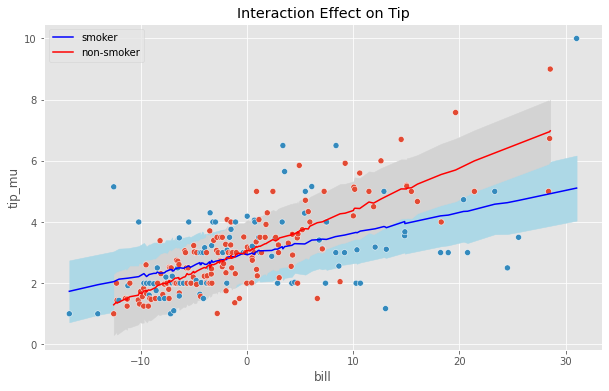

In [149]:
# colors are terrible - TO DO
plt.figure(figsize=(10, 6))
sns.lineplot(x=smoker_df['bill'], y=smoker_df['tip_mu'], color='blue')
plt.fill_between(smoker_df['bill'], smoker_df['tip_low'], smoker_df['tip_high'], color='lightblue')
sns.lineplot(x=nonsmoker_df['bill'], y=nonsmoker_df['tip_mu'], color='red')
plt.fill_between(nonsmoker_df['bill'], nonsmoker_df['tip_low'], nonsmoker_df['tip_high'], color='lightgrey')
sns.scatterplot(x=predictions['bill'], y=predictions['tip'], hue=predictions['smoker'])
plt.legend(['smoker', 'non-smoker'])
plt.title('Interaction Effect on Tip')
plt.show()

## 4.4 - Robust Regression

## 4.5 - Pooling, Multilevel Models, Mixed Effects